In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import geatpy as ea
plt.rcParams.update({'font.size': 15})

In [3]:
class emptyObject(object): pass

In [4]:
with open('allDend/mixedori/NMDA_ApN0.5_13_passive_r0_o2_i2_g_b0.pkl', 'rb') as fo:
    data = pickle.load(fo, encoding='bytes')
data = data[0]

In [5]:
def spike_time2spike_train(data):
    nReps = len(data.vdata)
    time_dur = len(data.vdata[0])
    Nsyn_e = 629
    Nsyn_i = 120
    spike_train = np.zeros((nReps, Nsyn_e+Nsyn_i, time_dur))
    for i in range(nReps):
        ind_etimes = (data.stim[:,0] == i + 1)
        etimes = np.array(data.stim[ind_etimes,:])
        etimes = etimes[:,(1,2)]
        for j in range(len(etimes)):
            spike_train[i, int(etimes[j, 0]), int(etimes[j, 1] * 5)] = 1

        ind_itimes = (data.stim[:,0] == -1 * i - 1)
        itimes = np.array(data.stim[ind_itimes,:])
        itimes = itimes[:,(1,2)]
        for j in range(len(itimes)):
            spike_train[i, int(itimes[j, 0]) + Nsyn_e, int(itimes[j, 1] * 5)] = 1
    return spike_train

In [6]:
X_train_array = spike_time2spike_train(data)
Y_train = np.array(data.vdata)

In [7]:
# standardization
Y_train_std = np.empty_like(Y_train)
Y_train_std = (Y_train - np.mean(Y_train)) / np.std(Y_train)

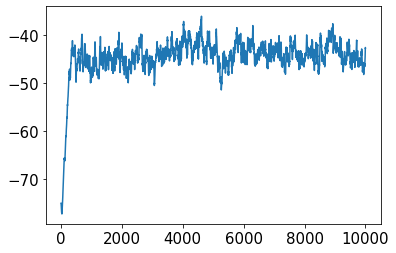

In [8]:
plt.plot(Y_train[0])

In [9]:
def kernel(tau_rise, tau_decay):
    T = np.arange(time_dur)
    y = (1 - np.exp(-T / tau_rise)) * np.exp(-T / tau_decay)
    return y

def sigmoid(X, c, theta):
    y = c / (1 + np.exp(-(X - theta)))
    return y

def model_non2(X, Omega, Tau_rise, Tau_decay, v0, c, theta):
    # X is one sample here
    Y = np.zeros(time_dur)
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        Y += Omega[i]*np.convolve(X[i], ker)[:time_dur]
    return sigmoid(Y, c, theta) + v0

def hlm_non2(X, Omega, Tau_rise, Tau_decay, v0, c, theta):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_non2(X[i], Omega, Tau_rise, Tau_decay, v0, c, theta)
    return Y

In [10]:
[1] * 5 + [2] * 3

[1, 1, 1, 1, 1, 2, 2, 2]

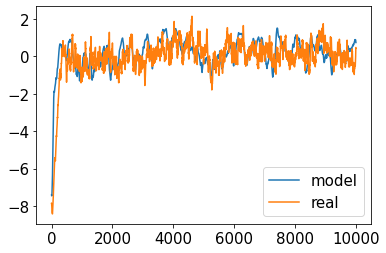

In [11]:
time_dur = len(Y_train_std[0])
Nsyn = len(X_train_array[0])
Vars = np.array([0.1] * 630 + [-0.1] * 119 +
                [75] * 749 +
                [40] * 749 + [-42, 45, -1.2])
y = model_non2(X_train_array[0], Vars[0:749], Vars[749:1498], Vars[1498:2247], Vars[-3], Vars[-2], Vars[-1])
plt.plot(y, label='model')
plt.plot(Y_train_std[0], label='real')
plt.legend()

In [12]:
def evalVars(Vars):
    y = hlm_non2(X_train_array, Vars[0:749], Vars[749:1498], Vars[1498:2247], Vars[-3], Vars[-2], Vars[-1])
    f = np.mean(np.square(y - Y_train_std))
    return f

In [13]:
evalVars(Vars)

0.7141246890868621

In [ ]:
res = minimize(evalVars, x0=Vars, method='BFGS', options={'disp': True, 'maxiter' : 1})
# with open('pars/pars_Neuron2018_test.p', 'wb') as f:
#     pickle.dump(res.x, f)